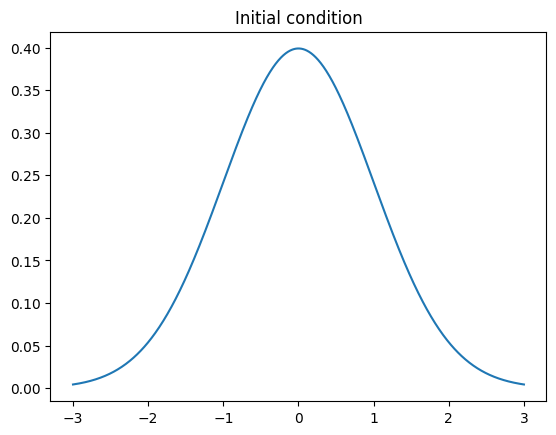

In [41]:
# NG implementation for Linear advection with a standard Gaussian bump
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

# Set up the linear advection
def advection_eq(u,x,t,c):
    du_dt= -c*jax.grad(u,x)
    return du_dt

x = jnp.linspace(-3.0,3.0, 1000)
x = x.reshape(-1, 1) 
'''
reshape the input into train_step
suggested by GPT
'''
T = 4.0 #end time
c = 1.0 #constat speed
# c= lambda t: jnp.sin(t)

# Uniformly sample from a standard Gaussian bump
targets=jnp.exp(-0.5*x**2)/jnp.sqrt(2*jnp.pi) 
#plot the initial condition
plt.plot(x, targets)
plt.title('Initial condition')
plt.show()
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x
    
rng = random.PRNGKey(0)
rng, key = random.split(rng)

model = MLP()
params = model.init(key, x)['params']



epoch:0 loss: 0.03484552353620529
epoch:1 loss: 0.005736046936362982
epoch:2 loss: 0.014996973797678947
epoch:3 loss: 0.005727520678192377
epoch:4 loss: 0.0008376208133995533
epoch:5 loss: 0.001279140473343432
epoch:6 loss: 0.0020912950858473778
epoch:7 loss: 0.003198418766260147
epoch:8 loss: 0.008271599188446999
epoch:9 loss: 0.001551975030452013
epoch:10 loss: 0.00024471167125739157
epoch:11 loss: 0.0018772834446281195
epoch:12 loss: 0.0035589500330388546
epoch:13 loss: 0.0002026956353802234
epoch:14 loss: 0.011303242295980453
epoch:15 loss: 0.0034094899892807007
epoch:16 loss: 5.617422721115872e-05
epoch:17 loss: 2.8833314900111873e-06
epoch:18 loss: 0.0090782530605793
epoch:19 loss: 0.0007024094229564071
epoch:20 loss: 0.0004132055037189275
epoch:21 loss: 0.0001762691099429503
epoch:22 loss: 0.0005090293707326055
epoch:23 loss: 0.0005504059372469783
epoch:24 loss: 0.0006174721056595445
epoch:25 loss: 0.0008906226139515638
epoch:26 loss: 0.0006055826088413596
epoch:27 loss: 0.00054

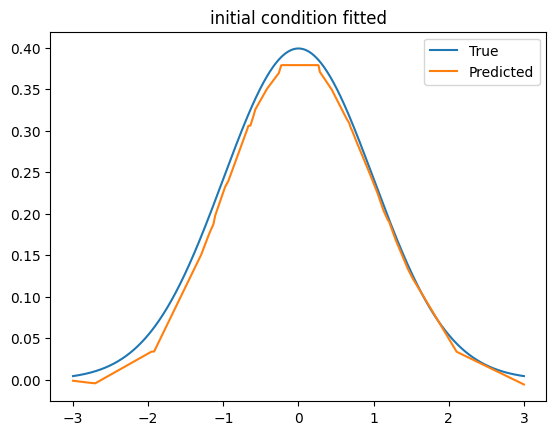

In [2]:
# Enforce the initial condition using ADAM to adjust the initial parameters
optimizer = optax.adam(learning_rate=1e-3,nesterov=False)
opt_state = optimizer.init(params)

#training step
@jit
def train_step(params, opt_state, inputs, targets):
    def mse(params, x, targets):
        u = model.apply({'params':params}, inputs)
        return jnp.mean((u - targets) ** 2)
    loss, grads = jax.value_and_grad(mse)(params, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, opt_state
##### wrong formula for relative error
# def check_rel_error(params):
#     xunif=jnp.linspace(-3.0,3.0, 6000)
#     xunif = xunif.reshape(-1, 1)
#     uunif=jnp.exp(-xunif**2)/jnp.sqrt(2*jnp.pi)
#     upred=model.apply({'params':params}, xunif)
#     rel_error=jnp.sum(uunif)/1000/0.997
#     print(f"Relative error: {rel_error}")
#     return rel_error
######
epochs=2000
bs=32
losses = []

for epoch in range(epochs):
    for i in range(0, len(x), bs):
        x_batch = x[i:i+bs]
        targets_batch = targets[i:i+bs]
        loss, params, opt_state = train_step(params, opt_state, x_batch, targets_batch)
        #losses.append(loss)
    print(f"epoch:{epoch} loss: {loss}")
    # if epoch%20==0: #check relative loss
    #     if check_rel_error(params)<0.01:
    #          break 
#check the initial condition
plt.figure()
plt.plot(x, targets, label='True')
plt.plot(x, model.apply({'params':params}, x), label='Predicted')
plt.title('initial condition fitted')
plt.legend()
plt.show()




In [ ]:
##### Given by Cheng, not useful
# # Define the loss function
# def mse_loss (params, model, inputs, targets) :
#     predictions = model. apply ({'params': params}, inputs)
#     return jnp.mean( (predictions - targets) ** 2)
# # Initialize the model and parameters
# x = jnp. linspace (-3.0, 3.0, 3000) . reshape (-1, 1) 
# targets = jnp.exp(-0.5 * x**2) / jnp.sqrt (2 * jnp.pi)
# rng = jax.random.PRNGKey (0)
# model = MLP ( )
# params = model.init (rng, x) ['params']
# # Gaussian bump
# # Get the gradient function of the loss with respect to the parameters
# grads_fn = jax.grad(mse_loss, argnums=0)
# # Compute gradients
# grads = grads_fn(params, model, x, targets)
# # If you want to flatten these gradients:
# flat_grads, _ = jax.tree_util.tree_flatten(grads)
# flat_grads = jnp.concatenate([jnp.ravel(g) for g in flat_grads])
# print( "Gradients of each parameter:")
# print(grads)
# print ("Flattened gradients:")
# print(flat_grads.shape)

In [39]:
#corrected theta update
def theta_update(params, input):
    # Define a function to compute the output of the network
    def model_output(params, x):
        output = model.apply({'params': params}, x)
        return output[0]
    
    # Compute gradient of the model output w.r.t. parameters
    grad_fn = jit(grad(model_output, argnums=0))
    
    # Define a function to flatten the gradients
    def flatten_grads(params, x):
        grads = grad_fn(params, x)
        flat_grads, _ = jax.tree_util.tree_flatten(grads)
        return jnp.concatenate([g.ravel() for g in flat_grads])

    treeshape= jax.tree_util.tree_structure(params)
    # Vectorize the function to handle batch inputs
    batch_flatten_grads = vmap(flatten_grads, in_axes=(None, 0))

    # Compute and flatten the gradients for all inputs
    flat_gradients = batch_flatten_grads(params, input)

    # Compute the corresponding predicted values at sampled points
    u_pred = model.apply({'params': params}, input).reshape(-1, 1)

    # Solve the least squares problem
    del_theta = jnp.linalg.lstsq(flat_gradients, u_pred, rcond=None)
    print(len(del_theta))
    print(len(params))

    # Check the number of leaves in del_theta and params
   # if len(jax.tree_util.tree_leaves(del_theta)) != len(jax.tree_util.tree_leaves(params)):
    #    raise ValueError("Number of leaves in del_theta and params do not match")

    # Unflatten the parameter updates
    #del_theta = jax.tree_util.tree_unflatten(jax.tree_util.tree_structure(params), del_theta)
    #check the dimensions first
    print(jax.tree_util.tree_flatten(params))
    print("heres the end ___________________")
    print(del_theta)
    #new_params = jax.tree_util.tree_flatten(params)+jax.tree_util.tree_flatten(del_theta)
    #new_params = jax.tree_util.tree_unflatten(treeshape, new_params)
    #new_params = jax.tree_multimap(lambda p, d: p + d, params, del_theta)

    return new_params

In [43]:
t = 0.0
T = 0.1
dt = 0.01
params = model.init(key, x)['params']

# Time-stepping loop
for i in range(int(T/dt)):
    # Update parameters using theta_update function
    params = theta_update(params, x)

    # Compute the new time 
    t += dt
    # Compute the solution at the new time step
    u = model.apply({'params': params}, x)

    # Plot the solution at each time step (optional)
    plt.plot(x, u)
    plt.title(f'Solution at t = {t:.2f}')
    plt.show()

# Plot the final solution
plt.plot(x, u)
plt.title('Final Solution')
plt.show()

4


KeyError: 0

In [66]:
##################### by GPT4
#### 
x=jnp.linspace(-3.0,3.0, 1000).reshape(-1, 1)

def theta_update(params, input):

    # Define a function to compute the output of the network
    def model_output(params, x):
        output=model.apply({'params': params}, x)
        return output[0] #to make it a scalar function, otherwise output has weird shape

    # Compute gradient of the model output w.r.t. parameters
    grad_fn = jit(grad(model_output, argnums=0))

    # Define a function to flatten the gradients
    def flatten_grads(params, x):
        grads = grad_fn(params, x)
        flat_grads, treedef = jax.tree_util.tree_flatten(grads)
        return jnp.concatenate([jnp.ravel(g) for g in flat_grads]),treedef

    # Vectorize the function to handle batch inputs
    batch_flatten_grads = vmap(flatten_grads, in_axes=(None, 0))
    # Compute and flatten the gradients for all inputs

    flat_gradients = batch_flatten_grads(params, x)
    print(flat_gradients.shape)

    # compute the corresponding predicted values at sampled points
    u_pred=model.apply({'params':params}, x).reshape(-1, 1)

    #now solve least squaer
 
    print(u_pred.shape)
    del_theta=jnp.linalg.lstsq(flat_gradients, u_pred, rcond=None)[0]

    #update parameters with unflattened del_theta
    del_theta = jax.tree_util.tree_unflatten(treedef, del_theta)
    new_params = jax.tree_multimap(lambda p, d: p + d, params, del_theta)


    return new_params



In [42]:
T=0.08
dt=0.02
N=int(T/dt)
t=0.0
def odeint_euler(fn,x,t,dt):
    return x+dt*jax.grad(fn(x,t))

# Time-stepping loop
for i in range(int(T/dt)):
    # Update parameters using theta_update function
    params = theta_update(params, x)

    u = model.apply({'params': params}, x)
    t+=dt
    #plot the solution against the true solution, which is a gaussian bump
    plt.plot(x, u, label='Predicted')
    targets=jnp.exp(-0.5*x**2)/jnp.sqrt(2*jnp.pi)
    plt.plot(x, targets, label='True')
    plt.title(f'Time: {t}')
    plt.show()
    
    

4


KeyError: 0